In [1]:
import string

import janitor  # noqa
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd  # noqa
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar

# from matplotlib.patches import Rectangle
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.utils import ROOT_DIR


In [2]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [3]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"

FIGURE_DIR.mkdir(parents=True, exist_ok=True)


In [4]:
# Load and combine all test and train predictions
pred_dir = ROOT_DIR / "models/predictions/global"
store = pred_dir / "ensemble_alltrain_10folds_combined.zarr"
pred = xr.open_zarr(store).pred_ensemble_alltrain_nogap_lnll_latest.rename("twsa_our")


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [5]:
# Zarr store paths
stores = [
    ROOT_DIR / "data/processed/targets.zarr",
    ROOT_DIR / "data/processed/inputs.zarr",
    ROOT_DIR / "data/processed/reconstructions.zarr",
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr",
]
ds_all = xr.merge([xr.open_zarr(store) for store in stores])

ds_all


<xarray.Dataset> Size: 69GB
Dimensions:                                    (lat: 360, lon: 720, time: 1480)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float64 6kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/59)
    land_mask_gsfc                             (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    land_mask_jpl                              (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_gsfc                                  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    twsa_jpl                                   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 360, 180), meta=np.ndarray>
    cell_area                                  (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    ...                                         ...
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(1480, 120, 120), meta=np.ndarray>
Attributes: (12/53)
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    time_coverage_start:           2002-04-16T00:00:00Z
    time_epoch:                    2002-01-01T00:00:00Z
    time_mean_removed:             2004.000 to 2009.999
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...

Specify variables of interest and their descriptive names:

In [6]:
# shorten name of our reconstruction
ds_all = ds_all.rename(pred_ensemble_alltrain_nogap_lnll_latest="twsa_our")


In [7]:
vars_verbose = {
    "twsa_our": "DeepWaters (Ours)",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_vars = vars_verbose.keys()


In [8]:
# Create and apply land mask
mask = (ds_all.land_mask_jpl * ds_all.land_mask_gsfc * ds_all.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)


Take global average of monthly values and take annual average:

In [9]:
global_monthly = ds_all[eval_vars].dw.weight_lat().mean(["lat", "lon"]).compute()
global_yearly = global_monthly.resample(time="YE").mean()


[########################################] | 100% Completed | 7.95 s


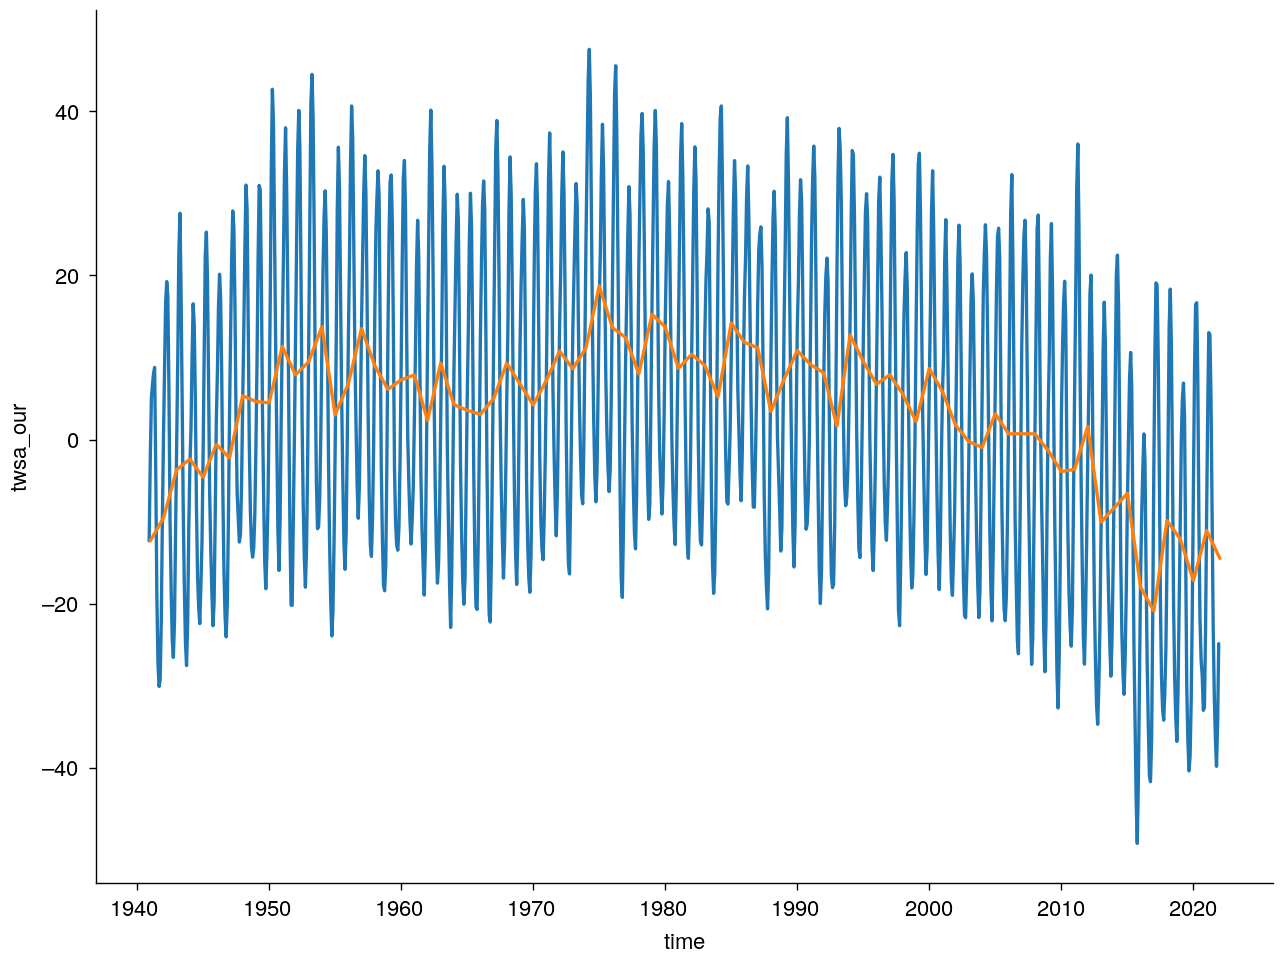

In [10]:
global_monthly.twsa_our.plot()
global_yearly.twsa_our.plot()


### Load GMSL Components

In [11]:
df = pd.read_excel(
    ROOT_DIR / "data/raw/inputs/sea-level/frederikse/global_basin_timeseries.xlsx"
)
df = df.rename(columns={df.columns[0]: "year"}).set_index("year")
df.columns = df.columns.str.replace(r"[\[\]]", "", regex=True)
df = df.clean_names()

# But bounds into separate dataframes
df_mean = df[df.columns[df.columns.str.endswith("mean")]]
df_upper = df[df.columns[df.columns.str.endswith("upper")]]
df_lower = df[df.columns[df.columns.str.endswith("lower")]]

df_mean.columns = df_mean.columns.str.replace("_mean", "")
df_upper.columns = df_upper.columns.str.replace("_upper", "")
df_lower.columns = df_lower.columns.str.replace("_lower", "")


Estimate TWSA from GMSL:

$$
    TWSA^* = GMSL - Steric - Ice_{GRL+ATA}

In [12]:
twsa_gmsl_obs = -(
    df_mean.observed_gmsl
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
twsa_gmsl_alt = -(
    df_mean.altimetry
    - df_mean.steric
    - df_mean.greenland_ice_sheet
    - df_mean.antarctic_ice_sheet
)
# Add Frederikses estimate (TWS + Glaciers)
twsa_frederikse = -(df_mean.terrestrial_water_storage + df_mean.glaciers)


In [13]:
# Convert to xarray
gmsl_dates = pd.to_datetime(dict(year=twsa_gmsl_obs.index, month=12, day=31))
da_twsa_gmsl_obs = xr.DataArray(
    twsa_gmsl_obs, coords={"time": gmsl_dates}, name="twsa_gmsl_obs"
)
da_twsa_gmsl_alt = xr.DataArray(
    twsa_gmsl_alt, coords={"time": gmsl_dates}, name="twsa_gmsl_alt"
)
# Also add Frederikses estimate (including Glaciers)
da_twsa_frederikse = xr.DataArray(
    twsa_frederikse,
    coords={"time": gmsl_dates},
    name="twsa_frederikse",
)

# Add to yearly variables
global_yearly = xr.merge(
    [global_yearly, da_twsa_gmsl_obs, da_twsa_gmsl_alt, da_twsa_frederikse]
)
vars_verbose.update(
    {
        "twsa_frederikse": "Frederikse (TWSA + Glaciers)",
        "twsa_gmsl_alt": "Sea level: Altimetry $-$ Steric $-$ Ice",
        "twsa_gmsl_obs": "Sea level: Tide gauges $-$ Steric $-$ Ice",
    }
)


In [14]:
# Subtract GRACE baseline
baseline = slice("2004", "2009")
global_yearly = global_yearly - global_yearly.sel(time=baseline).mean()


In [15]:
colors = sns.color_palette("tab20")
colors


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

In [16]:
# Create dictionaries for color lookup
yearly_colors = {
    "twsa_our": colors[0],
    "twsa_csr": colors[2],
    "twsa_gap": colors[4],
    "li_csr_full": colors[6],
    "yin_csr_full": colors[8],
    "twsa_frederikse": colors[10],
    "humphrey_gsfc_detrend": colors[12],
    "twsa_gmsl_alt": colors[16],
    "twsa_gmsl_obs": colors[18],
}
monthly_colors = {
    "twsa_our": colors[1],
    "twsa_csr": colors[3],
    "twsa_gap": colors[3],
    "li_csr_full": colors[7],
    "yin_csr_full": colors[9],
    "humphrey_gsfc_detrend": colors[13],
}


In [17]:
def plot_monthly(
    name: str, ax: plt.Axes, add_label: bool = False, **plot_kwargs
) -> mpl.lines.Line2D:
    """Plots the monthly time-series of the specified product"""
    (handle,) = ax.plot(
        global_monthly["time"],
        global_monthly[name],
        color=monthly_colors[name],
        label=vars_verbose[name] + ", monthly",
        **plot_kwargs,
    )
    return handle


def plot_yearly(
    name: str, ax: plt.Axes, add_label: bool = False, **plot_kwargs
) -> mpl.lines.Line2D:
    """Plots the yearly time-series of the specified product"""
    (handle,) = ax.plot(
        global_yearly["time"],
        global_yearly[name],
        color=yearly_colors[name],
        label=vars_verbose[name],
        **plot_kwargs,
    )
    return handle


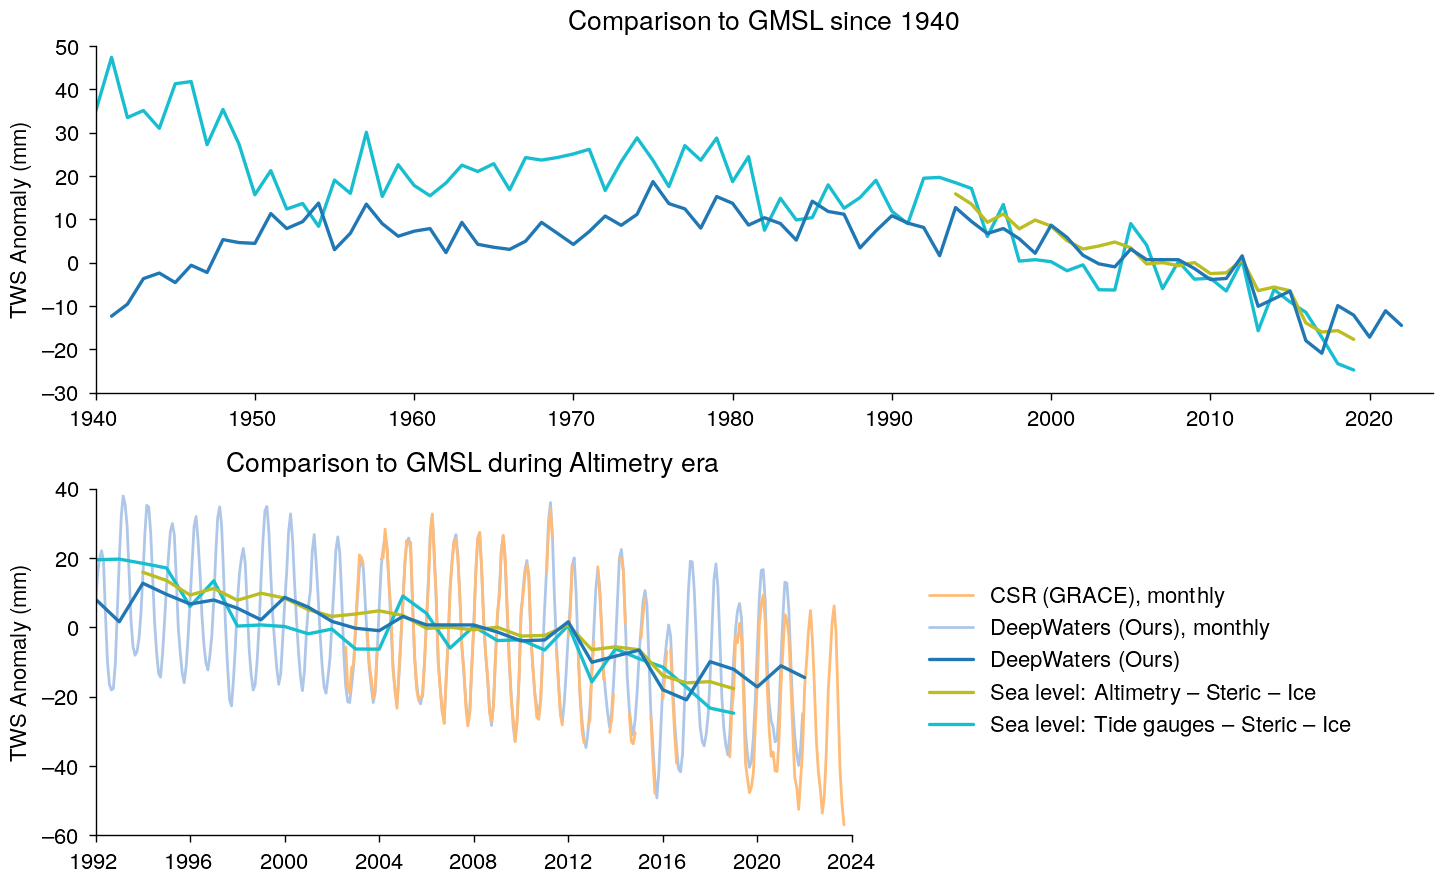

In [18]:
fig = plt.figure(figsize=(7.2, 4.4))
gs = fig.add_gridspec(2, 2, width_ratios=[1.4, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])

# PLOT 1 (Ours and comparison, yearly 1940-now)

locator = ticker.MultipleLocator(10)

plot_yearly("twsa_gmsl_obs", ax1)
plot_yearly("twsa_gmsl_alt", ax1)
plot_yearly("twsa_our", ax1)

ax1.set(
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2024")),
    ylim=(-30, 50),
    ylabel="TWS Anomaly (mm)",
)
ax1.set_title("Comparison to GMSL since 1940")
ax1.yaxis.set_major_locator(locator)

# PLOT 2 (Ours and GRACE, monthly + yearly, Altimetry era)

l_ours_monthly = plot_monthly("twsa_our", ax2, linewidth=1.0)
l_csr_monthly = plot_monthly("twsa_csr", ax2, linewidth=1.0)
l_obs = plot_yearly("twsa_gmsl_obs", ax2)
l_alt = plot_yearly("twsa_gmsl_alt", ax2)
l_ours = plot_yearly("twsa_our", ax2)

ax2.set(
    xlim=(pd.Timestamp("1992"), pd.Timestamp("2024")),
    ylim=(-60, 40),
    ylabel="TWS Anomaly (mm)",
)
ax2.set_title("Comparison to GMSL during Altimetry era")


# Manually sort legend
handles = [l_csr_monthly, l_ours_monthly, l_ours, l_alt, l_obs]
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.63, 0.25))

fig.savefig(FIGURE_DIR / "gmsl_comparison_wo-others.pdf", backend="pgf")


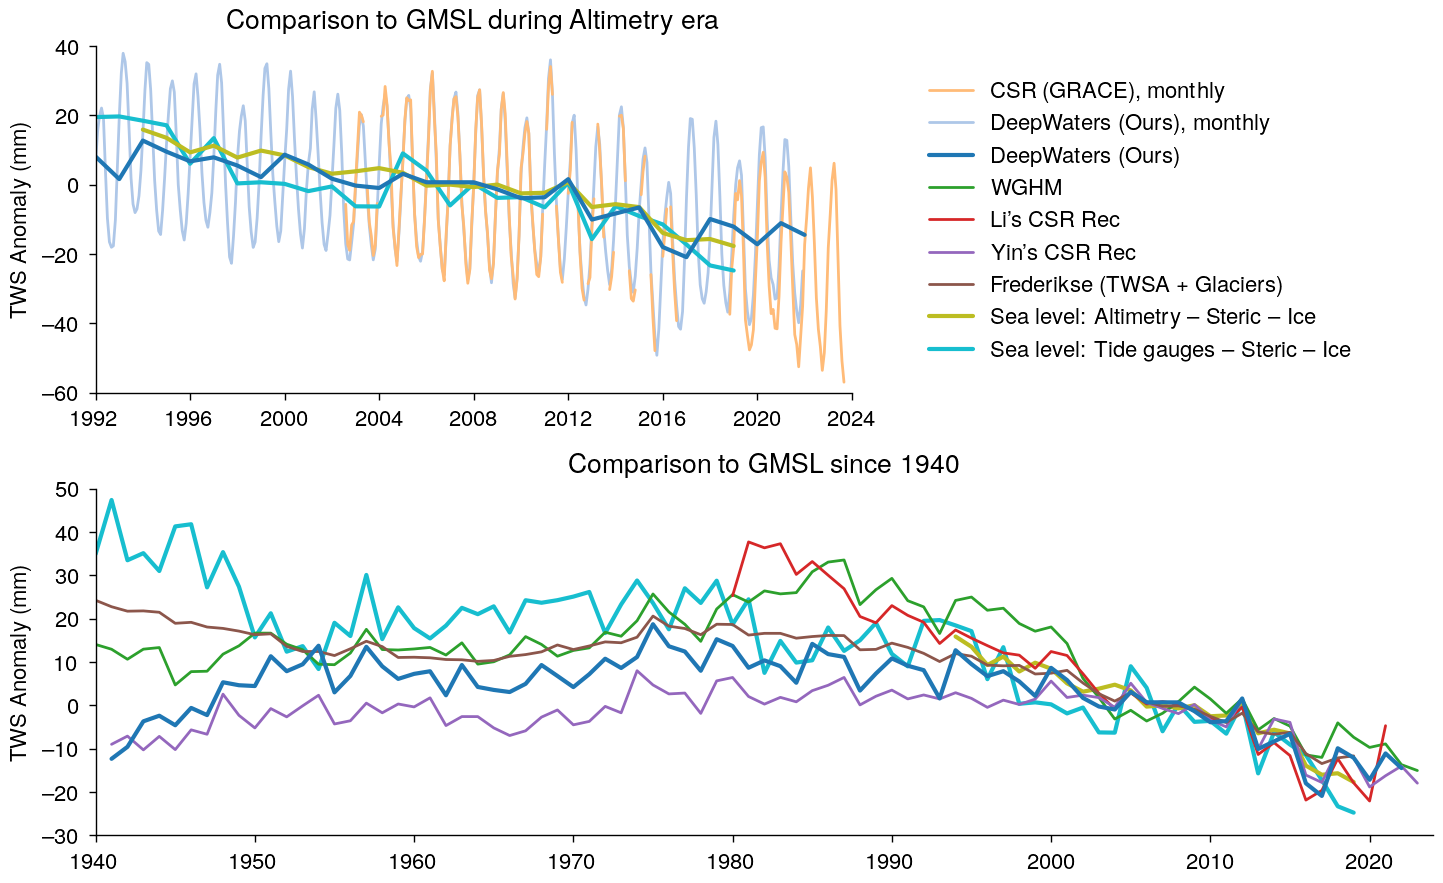

In [19]:
fig = plt.figure(figsize=(7.2, 4.4))
gs = fig.add_gridspec(2, 2, width_ratios=[1.4, 1], hspace=0.05)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, :])

# PLOT 1 (Ours and GRACE, monthly + yearly, Altimetry era)

l_ours_monthly = plot_monthly("twsa_our", ax1, linewidth=1.0)
l_csr_monthly = plot_monthly("twsa_csr", ax1, linewidth=1.0)
l_obs = plot_yearly("twsa_gmsl_obs", ax1, linewidth=1.5)
l_alt = plot_yearly("twsa_gmsl_alt", ax1, linewidth=1.5)
l_ours = plot_yearly("twsa_our", ax1, linewidth=1.5)

ax1.set(
    xlim=(pd.Timestamp("1992"), pd.Timestamp("2024")),
    ylim=(-60, 40),
    ylabel="TWS Anomaly (mm)",
)
ax1.set_title("Comparison to GMSL during Altimetry era")

# PLOT 2 (Ours and comparison, yearly 1940-now)

locator = ticker.MultipleLocator(10)

plot_yearly("twsa_gmsl_obs", ax2, linewidth=1.5)
plot_yearly("twsa_gmsl_alt", ax2, linewidth=1.5)
l_gap = plot_yearly("twsa_gap", ax2, linewidth=1.0)
l_li = plot_yearly("li_csr_full", ax2, linewidth=1.0)
l_yin = plot_yearly("yin_csr_full", ax2, linewidth=1.0)
l_fred = plot_yearly("twsa_frederikse", ax2, linewidth=1.0)
plot_yearly("twsa_our", ax2, linewidth=1.5)

ax2.set(
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2024")),
    ylim=(-30, 50),
    ylabel="TWS Anomaly (mm)",
)
ax2.set_title("Comparison to GMSL since 1940")
ax2.yaxis.set_major_locator(locator)

# Manually sort legend
handles = [
    l_csr_monthly,
    l_ours_monthly,
    l_ours,
    l_gap,
    l_li,
    l_yin,
    l_fred,
    l_alt,
    l_obs,
]
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.63, 0.75))

fig.savefig(FIGURE_DIR / "gmsl_comparison_w-others.pdf", backend="pgf")


## Ability to close the sea level budget

Calculate the error and correlation between the reconstructions and the product

In [20]:
TIME_PERIODS = [
    ("1940", "1959"),
    ("1960", "1979"),
    ("1980", "2002-03"),
    ("2002-04", "2018"),
]


In [21]:
# Evaluation variables (remove GMSL)
da_eval = global_yearly.drop_vars(["twsa_gmsl_alt", "twsa_gmsl_obs"])

df_errors = []

for period in TIME_PERIODS:
    # Iterate over different time periods
    da_true_period = global_yearly.twsa_gmsl_obs.sel(time=slice(*period))
    da_eval_period = da_eval.sel(time=slice(*period))
    # Calculate the RMSE
    da_error = metrics.rmse(da_true_period, da_eval_period, skipna=True)
    # Convert to data frame
    df_error = (
        da_error.to_pandas()
        .rename("model")
        .reset_index(name="error")
        .rename(columns={"index": "model"})
    )
    # Add decriptive names
    df_error["model_verbose"] = df_error["model"].map(vars_verbose)

    df_errors.append(df_error)


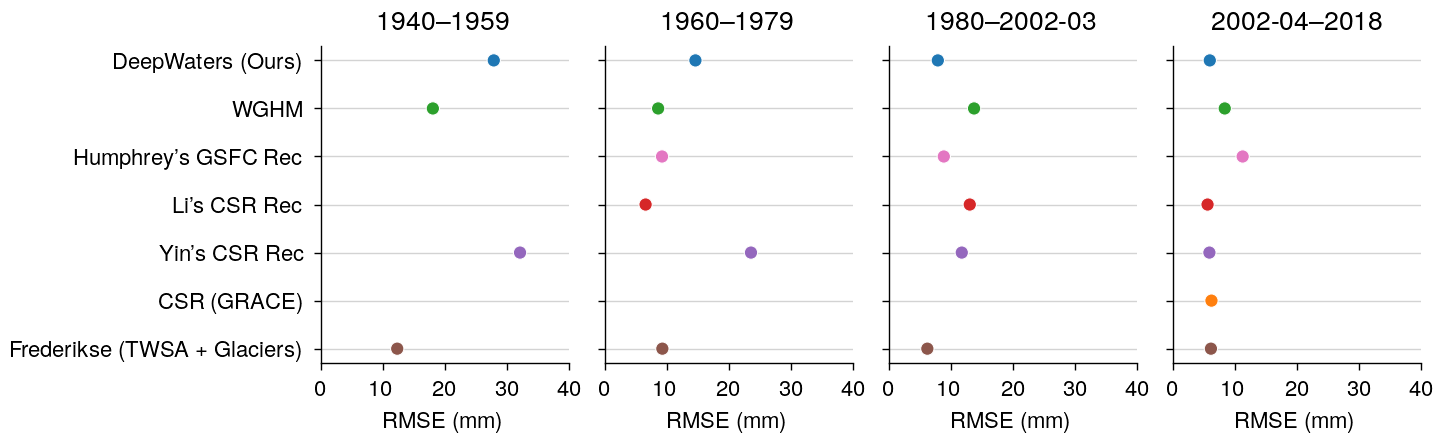

In [22]:
fig, axs = plt.subplots(
    ncols=len(TIME_PERIODS), sharex=True, sharey=True, figsize=(7.2, 2.2)
)


# Plot

locator = ticker.MultipleLocator(10)

for ax, period, df_error in zip(axs, TIME_PERIODS, df_errors):
    sns.scatterplot(
        df_error,
        x="error",
        y="model_verbose",
        hue="model",
        palette=yearly_colors,
        ax=ax,
        legend=False,
    )
    ax.set(xlabel="RMSE (mm)", ylabel=None, title=f"{period[0]}--{period[1]}")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(locator)

axs[0].set(xlim=(0, 40))

fig.savefig(FIGURE_DIR / "gmsl_closure_rmse.pdf", backend="pgf")


## Combine

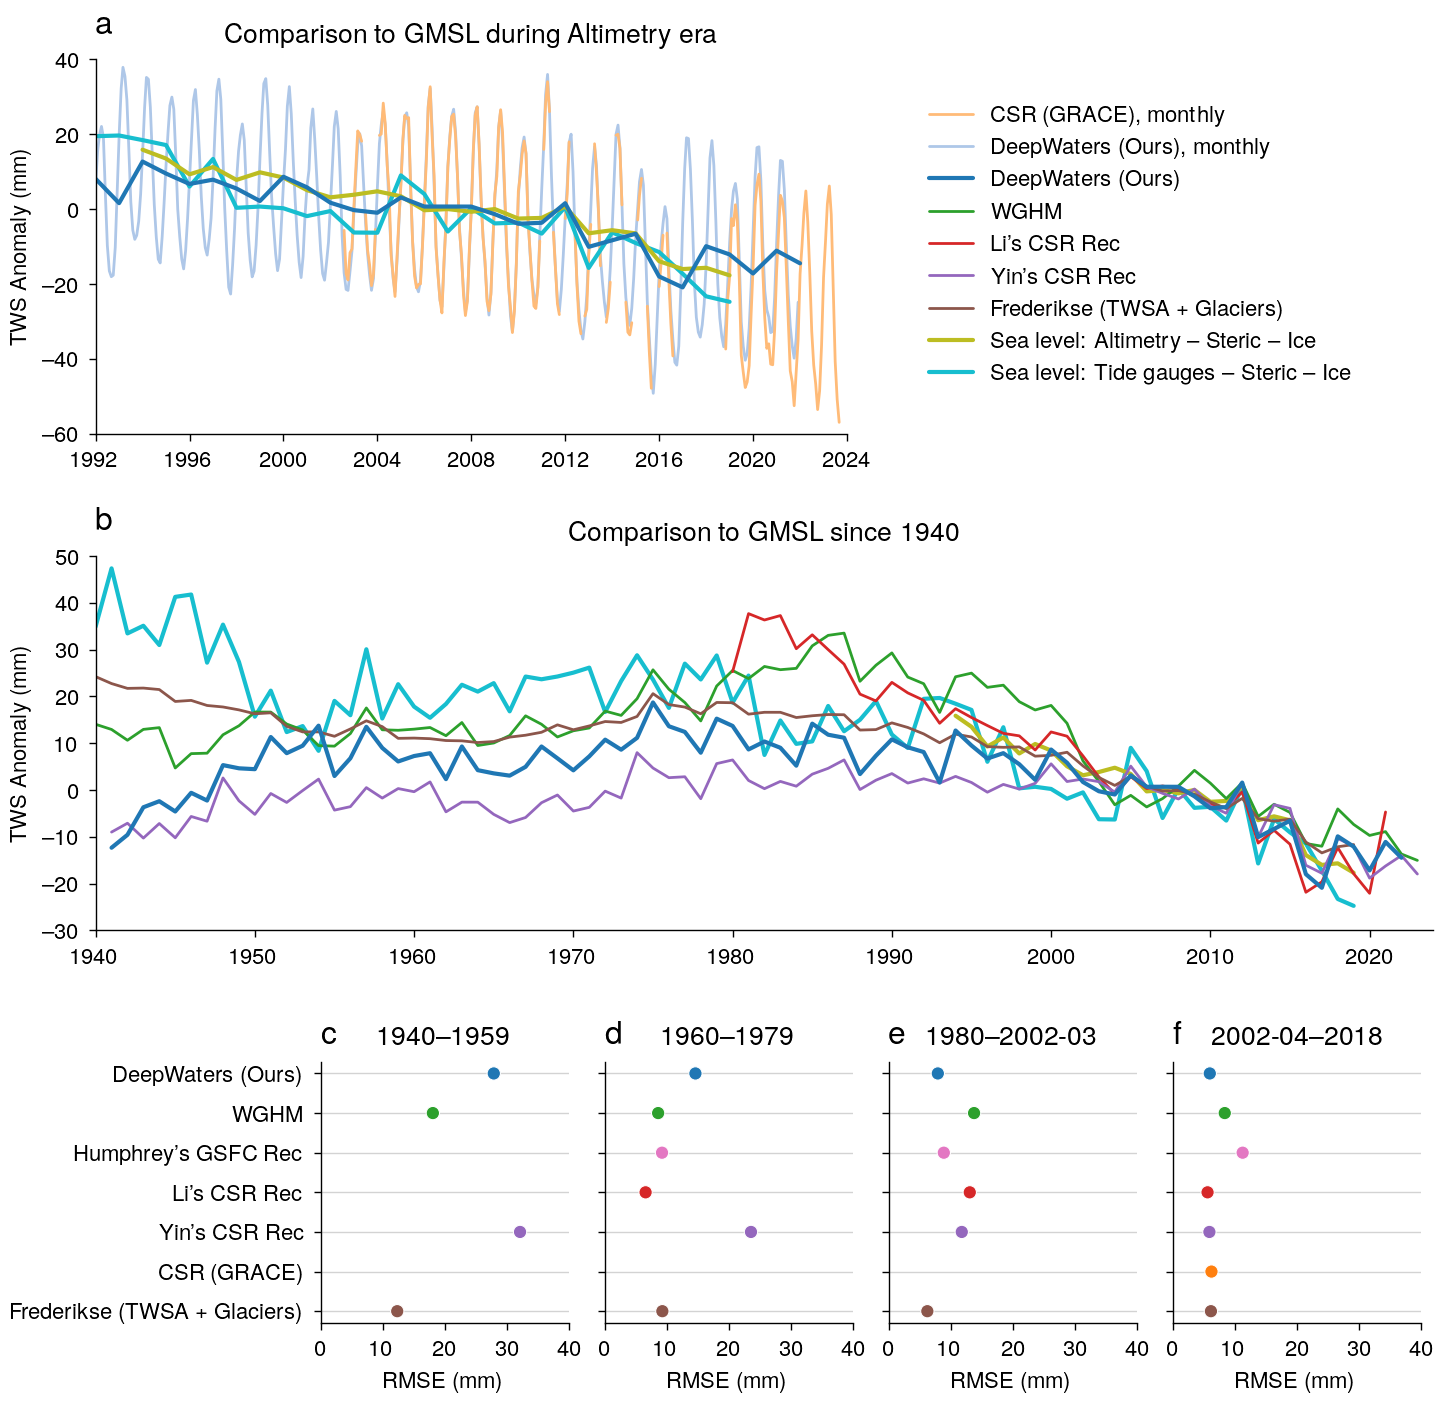

In [23]:
fig = plt.figure(figsize=(7.2, 7))
fig_line, fig_point = fig.subfigures(nrows=2, hspace=0.05, height_ratios=[2.5, 1])
gs = fig_line.add_gridspec(2, 2, width_ratios=[1.4, 1], hspace=0.05)
ax1 = fig_line.add_subplot(gs[0, 0])
ax2 = fig_line.add_subplot(gs[1, :])
axs_point = fig_point.subplots(ncols=len(TIME_PERIODS), sharex=True, sharey=True)

# PLOT 1 (Ours and GRACE, monthly + yearly, Altimetry era)

l_ours_monthly = plot_monthly("twsa_our", ax1, linewidth=1.0)
l_csr_monthly = plot_monthly("twsa_csr", ax1, linewidth=1.0)
l_obs = plot_yearly("twsa_gmsl_obs", ax1, linewidth=1.5)
l_alt = plot_yearly("twsa_gmsl_alt", ax1, linewidth=1.5)
l_ours = plot_yearly("twsa_our", ax1, linewidth=1.5)

ax1.set(
    xlim=(pd.Timestamp("1992"), pd.Timestamp("2024")),
    ylim=(-60, 40),
    ylabel="TWS Anomaly (mm)",
    title="Comparison to GMSL during Altimetry era",
)

# PLOT 2 (Ours and comparison, yearly 1940-now)

locator = ticker.MultipleLocator(10)

plot_yearly("twsa_gmsl_obs", ax2, linewidth=1.5)
plot_yearly("twsa_gmsl_alt", ax2, linewidth=1.5)
l_gap = plot_yearly("twsa_gap", ax2, linewidth=1.0)
l_li = plot_yearly("li_csr_full", ax2, linewidth=1.0)
l_yin = plot_yearly("yin_csr_full", ax2, linewidth=1.0)
l_fred = plot_yearly("twsa_frederikse", ax2, linewidth=1.0)
plot_yearly("twsa_our", ax2, linewidth=1.5)

ax2.set(
    xlim=(pd.Timestamp("1940"), pd.Timestamp("2024")),
    ylim=(-30, 50),
    ylabel="TWS Anomaly (mm)",
    title="Comparison to GMSL since 1940",
)
ax2.yaxis.set_major_locator(locator)

# Manually sort legend
handles = [
    l_csr_monthly,
    l_ours_monthly,
    l_ours,
    l_gap,
    l_li,
    l_yin,
    l_fred,
    l_alt,
    l_obs,
]
fig_line.legend(handles=handles, loc="center left", bbox_to_anchor=(0.63, 0.75))

# PLOT 3 (Budget closure pointplot)

locator2 = ticker.MultipleLocator(10)

for ax, period, df_error in zip(axs_point, TIME_PERIODS, df_errors):
    sns.scatterplot(
        df_error,
        x="error",
        y="model_verbose",
        hue="model",
        palette=yearly_colors,
        ax=ax,
        legend=False,
    )
    ax.set(xlabel="RMSE (mm)", ylabel=None, title=f"{period[0]}--{period[1]}")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(locator2)

axs_point[0].set(xlim=(0, 40))

# Add letters
for n, ax in enumerate([ax1, ax2, *axs_point]):
    ax.text(
        0.0,
        1.0 + 0.07,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "gmsl_comparison.pdf", backend="pgf")
